In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
import scipy
from scipy.special import erf
import numpy
from numpy import exp
from numpy.lib.scimath import log, sqrt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (13, 7)


## Exercise 5.01 ##
In this exercise we are required to use the Metropolis-Hastings algorithm to sample from the probability density function of the position of an electron trapped in a central coulomb potential
To sample from the distribution we will use the Metropolis-hastings algorithm.

To ensure an efficient exploration of the entire space we have to choose a jump function. As a rule of thumb we try to choose a jump function for which the rejection rate is $\approx 50%$. By an empirical exploration we got to the conclusion that:
<ul>
  <li>for the ground state, an acceptance rate of $\approx50%$ is achieved by jumps with components sampled from a uniform distribution on $[-1.25,1.25]$ or from a normal distribution with mean $0$ and standard deviation $1$</li>
  <li>for the state $|210\rangle$, an acceptance rate of $\approx50%$ is achieved by jumps with components sampled from a uniform distribution on $[-3,3]$ or from a normal distribution with mean $0$ and standard deviation $3$</li>
</ul>
The distances are measured in units of $a_0$, the Bohr radius

After deciding the jump function we have to choose the starting point, and this is a thorny problem: if we start from a low probability point we have to wait for the metropolis algorithm to get to the higher-probability region. It should be observed that in doing this we are supposing that such region exists and is unique, and that's not always the case.

To get a reasonable starting point we will start from a seemingly random position $(0,0,150)$ and we'll look if we "get stuck" in a specific position

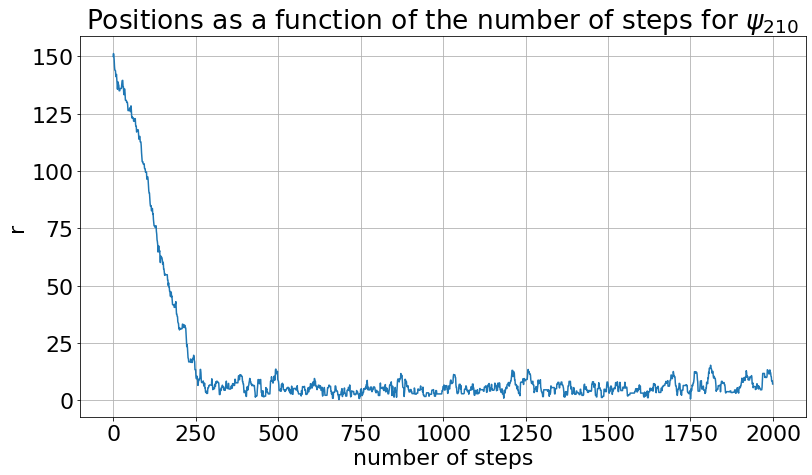

In [3]:
df=pd.read_csv(r'waveFunctionSampling\waveFunctionSampling.csv')
X=df.x;
Y=df.y;
Z=df.z;
r=(np.sqrt(df.x**2+df.y**2+df.z**2))
plt.xlabel('number of steps')
plt.ylabel('r')
plt.plot(r[0:2000]);
plt.grid();
plt.title(r'Positions as a function of the number of steps for $\psi_{210}$');

In the previous section we plotted the $r^2$ value as a function of the number of steps, using uniform steps. We clearly see that the value quickly settles around $1$. From the theory we know the true value: for $\psi_{210}$ the mean radius should be $5$. We could do a more elaborate analysis to get a more precise value(for example we could take the mean over a certain number of steps) but we'd expect no substantial gain.A similar analysis conducted for $psi_{100}$ suggests us the same: the mean radius is of the order of the Bohr radius.

To avoid any major error we can plot the point we obtained. the next two graphs show the 2d histograms and the scatter plot for $\psi_{210}$

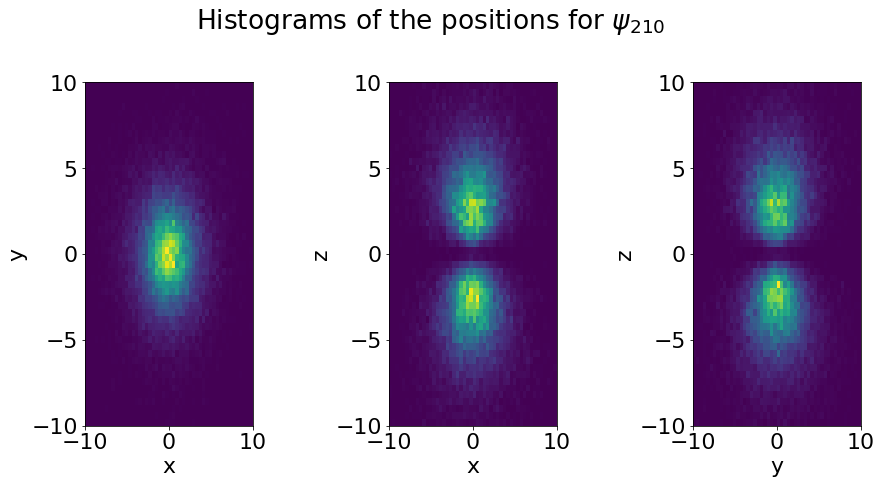

In [4]:
fig, axs = plt.subplots(1, 3);
axs[0].hist2d(X,Y, bins=(50,50),range=[[-10,10], [-10,10]]);
axs[0].set_xlabel('x');
axs[0].set_ylabel('y');
axs[1].hist2d(X,Z, bins=(50,50),range=[[-10,10], [-10,10]]);
axs[1].set_xlabel('x');
axs[1].set_ylabel('z');
im=axs[2].hist2d(Y,Z, bins=(50,50),range=[[-10,10], [-10,10]]);
axs[2].set_xlabel('y');
axs[2].set_ylabel('z');
plt.suptitle(r'Histograms of the positions for $\psi_{210}$')
plt.tight_layout()

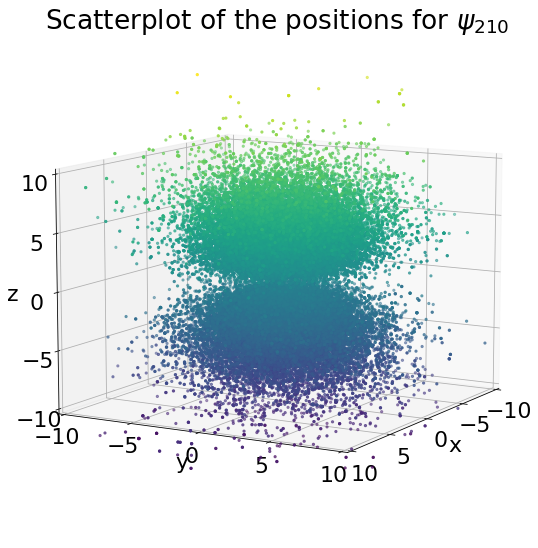

In [5]:
df=df[df.z<20]
X=df.x
Y=df.y
Z=df.z

fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X, Y, Z, c=Z, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d([-10,10])
ax.set_ylim3d([-10,10])
ax.set_zlim3d([-10,10])
ax.view_init(10, 30)
plt.title(r'Scatterplot of the positions for $\psi_{210}$')
plt.show();

We can see that the probability is very small on the plane $z=0$, therefore we will choose as a starting point $(0,0,1)$ to avoid arithmetic errors.
In the next section we plot the cumulative square radius and the statistical uncertainty obtained by using data blocking, with 100 blocks of length 1000

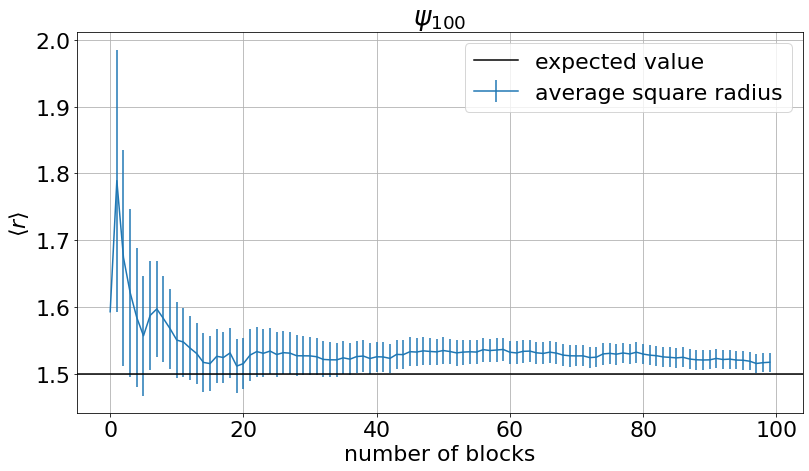

In [6]:
df=pd.read_csv(r'waveFunctionMetropolis\psi100Averages.csv')
plt.errorbar(range(0,df.r2.size), y=df.r2, yerr=df.err, label='average square radius');
plt.axhline(y=1.5,label='expected value',color='black');
plt.title(r"$\psi_{100}$")
plt.xlabel("number of blocks")
plt.ylabel(r"$\langle r \rangle$")
plt.grid()
plt.legend();

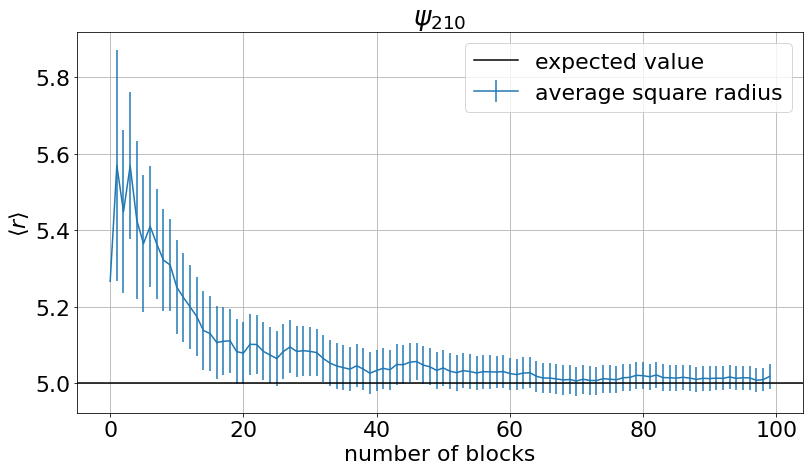

In [7]:
df=pd.read_csv(r'waveFunctionMetropolis\psi210Averages.csv')
plt.errorbar(range(0,df.r2.size), y=df.r2, yerr=df.err, label='average square radius');
plt.axhline(y=5,label='expected value',color='black');
plt.title(r"$\psi_{210}$")
plt.xlabel("number of blocks")
plt.ylabel(r"$\langle r \rangle$")
plt.grid()
plt.legend();

A natural question that arises is the role of the jumping probabilities: do we expect a significant effect if we jump according to a Gauss distribution? In the next blocks of code the progressive mean obtained using datablocking and the estimated errors are reported as a function of the number of blocks, and we can observe a reasonable agreement between the simulated value and the theoretical one

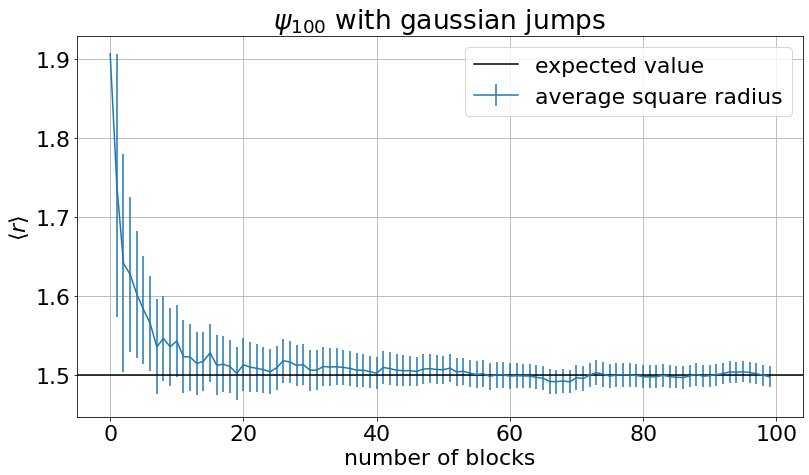

In [8]:
df=pd.read_csv(r'waveFunctionMetropolis\psi100AveragesGaussianJumps.csv')
plt.errorbar(range(0,df.r2.size), y=df.r2, yerr=df.err, label='average square radius');
plt.axhline(y=1.5,label='expected value',color='black');
plt.title(r"$\psi_{100}$ with gaussian jumps")
plt.xlabel("number of blocks")
plt.ylabel(r"$\langle r \rangle$")
plt.grid()
plt.legend();

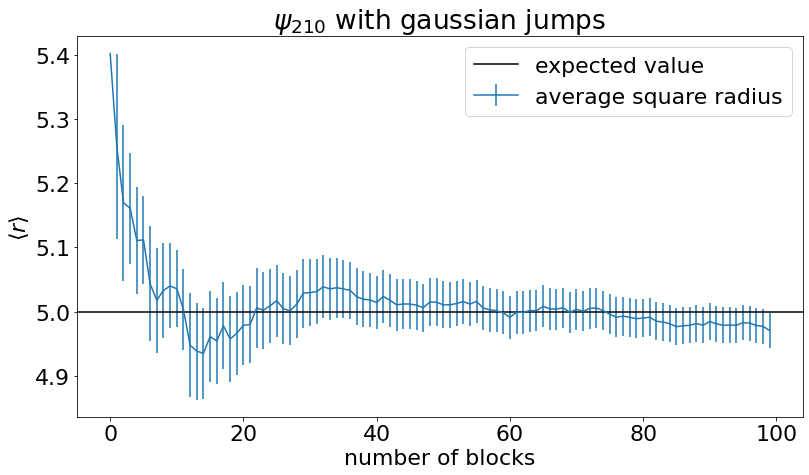

In [9]:
df=pd.read_csv(r'waveFunctionMetropolis\psi210AveragesGaussianJumps.csv')
plt.errorbar(range(0,df.r2.size), y=df.r2, yerr=df.err, label='average square radius');
plt.axhline(y=5,label='expected value',color='black');
plt.title(r"$\psi_{210}$ with gaussian jumps")
plt.xlabel("number of blocks")
plt.ylabel(r"$\langle r \rangle$")
plt.grid()
plt.legend();

## Block length and self correlation ##
We also wish to examine the self correlation. How do we know that we choose blocks long enough to break the autocorrelation?


In [10]:
def selfCorrelation(ts,r):
    selfCorrelations = []
    meanR=np.mean(r)
    variance=np.var(r)
    r=np.array(r-meanR)
    for t in ts:
        selfCorrelations.append(np.sum([((r[i]*r[i+t])/(len(r)-t)) for i in range(1,len(r)-t)]))
    selfCorrelations=np.array(selfCorrelations)/variance
    return selfCorrelations


100000


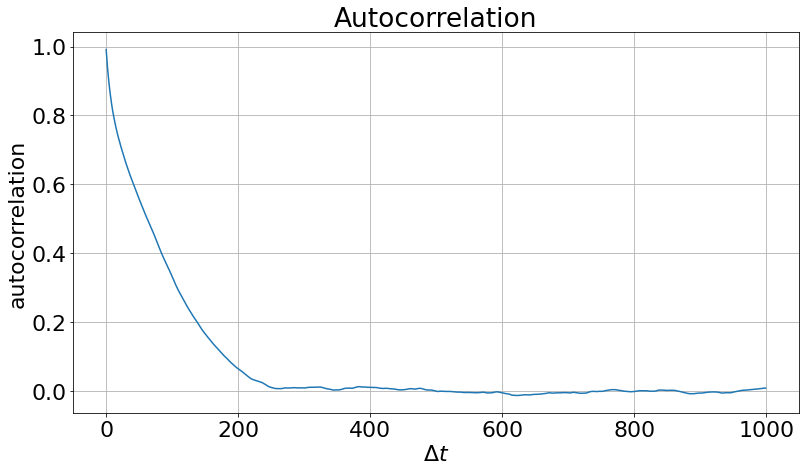

In [11]:
df=pd.read_csv(r'waveFunctionSampling\waveFunctionSampling.csv')
print(len(r))
r=(np.sqrt(df.x**2+df.y**2+df.z**2))
t=range(0,1000)
autocorrs=[]
selfcorr= selfCorrelation(t,r);
plt.xlabel(r'$\Delta t$')
plt.ylabel('autocorrelation')
plt.plot(selfcorr);
plt.title('Autocorrelation');
plt.grid()
plt.show();